# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

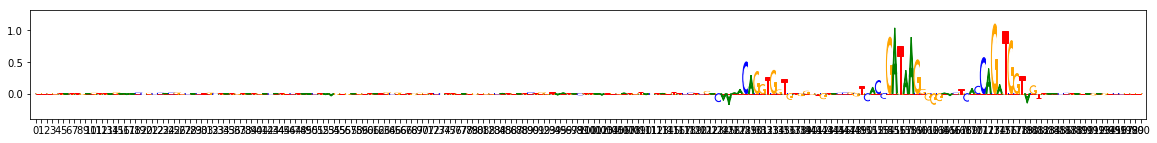

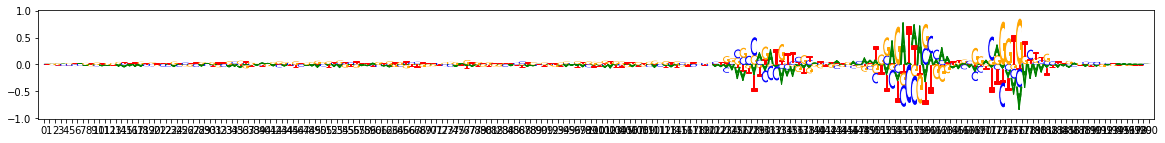

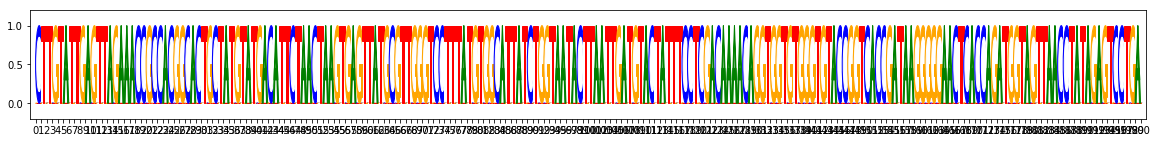

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size `sliding_window_size` and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see `examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb` for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that `target_seqlet_fdr`. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.024238208562135696
Computing threshold
Thresholds from null dist were -1.507358968257904  and  1.0946837365627289
Final raw thresholds are -1.507358968257904  and  1.0946837365627289
Final transformed thresholds are -0.8822043010752688  and  0.8538575268817205


TF-MoDISco is using the TensorFlow backend.


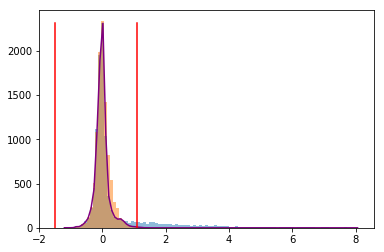

Got 1449 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= 0.008967273518210276
Computing threshold
Thresholds from null dist were -0.9324653744697571  and  0.643557071685791
Final raw thresholds are -0.9324653744697571  and  0.643557071685791
Final transformed thresholds are -0.9025672043010753  and  0.8852486559139785


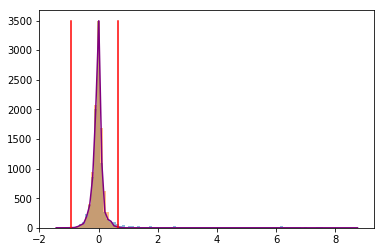

Got 1172 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.000643205642700196
Computing threshold
Thresholds from null dist were -0.6486682891845703  and  0.7166275978088379
Final raw thresholds are -0.6486682891845703  and  0.7166275978088379
Final transformed thresholds are -0.8742069892473119  and  0.8798991935483871


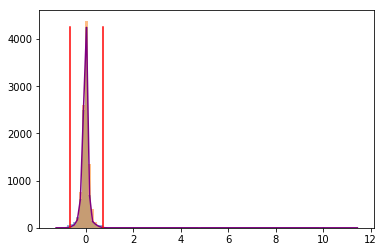

Got 1269 coords
After resolving overlaps, got 2200 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8538574268817205
2200 identified in total
6 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [698, 697, 298, 134, 121, 118]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '1,1,1', 3: '0,0,-1', 4: '0,1,-1', 5: '0,1,0'}
On metacluster 5
Metacluster size 118
Relevant tasks:  ('task1',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 118
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.12 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Com

Using TensorFlow backend.


Job completed in: 0.51 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.44 s
(Round 1) Computed affinity matrix on nearest neighbors in 1.01 s
Filtered down to 85 of 118
(Round 1) Retained 85 rows out of 118 after filtering
(Round 1) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 85 samples in 0.000s...
[t-SNE] Computed neighbors for 85 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 85 / 85
[t-SNE] Mean sigma: 0.231067
(Round 1) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00716185569763 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 1.97126889229 seconds
Wrote graph to binary file in 0.00551891326904 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.681786
Louvain completed 51 runs in 0.843836069107 seconds
Preproc + Louvain took 2.87535119057 s
Got 6 clusters after round 1
Count

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Job completed in: 0.31 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.43 s
(Round 2) Computed affinity matrix on nearest neighbors in 0.78 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.000s...
[t-SNE] Computed neighbors for 74 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.217858
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00744104385376 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 1.97522091866 seconds
Wrote graph to binary file in 0.0039849281311 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.802693
Louvain completed 51 runs in 0.924468994141 seconds
Preproc + Louvain took 2.95128798485 s
Got 7 clusters after round 2
Counts:
{0: 14, 1: 13, 2: 12, 3: 11

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Computing pattern to pattern distances
Collapsing 0 & 3 with prob 2.506197548371082e-05 and sim 0.9825315918325778
Collapsing 0 & 5 with prob 0.0001126743967045442 and sim 0.9786122837068685
Collapsing 0 & 2 with prob 1.0051202423897486e-05 and sim 0.9752120014980257
Collapsing 1 & 3 with prob 3.962527653300229e-06 and sim 0.9668731241908217
Collapsing 2 & 5 with prob 3.884018956381963e-06 and sim 0.965663634493194
Collapsing 0 & 6 with prob 3.1938447153206667e-06 and sim 0.9593648954504389
Collapsing 3 & 5 with prob 3.924236265587317e-06 and sim 0.9573017157665152
Collapsing 0 & 1 with prob 1.59758071882568e-05 and sim 0.9546501717039249
Collapsing 1 & 6 with prob 1.0989655352787782e-06 and sim 0.9535328675112518
Collapsing 5 & 6 with prob 5.112773167157624e-06 and sim 0.9476824779866206
Collapsing 1 & 5 with prob 1.995206327946599e-06 and sim 0.9164301133660552
Trimmed 0 out of 24
Skipped 1 seqlets
Trimmed 0 out of 32
Trimmed 0 out of 44
Trimmed 1 out of 57
Trimmed 5 out of 61
On mer

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Job completed in: 0.54 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.56 s
(Round 2) Computed affinity matrix on nearest neighbors in 1.18 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 98 samples in 0.000s...
[t-SNE] Computed neighbors for 98 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 98 / 98
[t-SNE] Mean sigma: 0.222270
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00828695297241 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.08166885376 seconds
Wrote graph to binary file in 0.0105199813843 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.659409
After 9 runs, maximum modularity is Q = 0.678845
Louvain completed 59 runs in 1.03267598152 seconds
Preproc + Louvain took 3.17284202576 s
Got 8 clusters a

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Computing pattern to pattern distances
Collapsing 1 & 3 with prob 6.320891498340013e-06 and sim 1.8604446222855002
Collapsing 0 & 1 with prob 1.2973316282429328e-05 and sim 1.8245711032303298
Trimmed 0 out of 30
Trimmed 0 out of 58
On merging iteration 2
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 6 patterns after merging
Performing seqlet reassignment
Got 0 patterns after reassignment
Total time taken is 13.05s
On metacluster 3
Metacluster size 134
Relevant tasks:  ('task2',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 134
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.04 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest ne

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Job completed in: 0.32 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.34 s
(Round 2) Computed affinity matrix on nearest neighbors in 0.7 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 67 samples in 0.000s...
[t-SNE] Computed neighbors for 67 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 67 / 67
[t-SNE] Mean sigma: 0.361967
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.00756692886353 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 1.97629904747 seconds
Wrote graph to binary file in 0.00433993339539 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.6645
After 3 runs, maximum modularity is Q = 0.682262
After 23 runs, maximum modularity is Q = 0.685153
Louvain completed 73 runs in 1.27646803856 seconds
Preproc

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished


Computing pattern to pattern distances
Got 6 patterns after merging
Performing seqlet reassignment
Got 0 patterns after reassignment
Total time taken is 10.61s
On metacluster 2
Metacluster size 298
Relevant tasks:  ('task0', 'task1', 'task2')
Relevant signs:  (1, 1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 298
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.08 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.01 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 5.11 s
Launching nearest neighbors affmat calculation job
Job completed in: 5.24 s

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished


Job completed in: 3.46 s
Launching nearest neighbors affmat calculation job
Job completed in: 3.58 s
(Round 2) Computed affinity matrix on nearest neighbors in 7.56 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 247 samples in 0.000s...
[t-SNE] Computed neighbors for 247 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 247 / 247
[t-SNE] Mean sigma: 0.210327
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0173890590668 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.42805600166 seconds
Wrote graph to binary file in 0.0288419723511 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.600967
After 3 runs, maximum modularity is Q = 0.602074
After 11 runs, maximum modularity is Q = 0.604051
After 13 runs, maximum modularity is Q = 0.631077
Aft

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


Computing pattern to pattern distances
Collapsing 0 & 3 with prob 7.25113829539336e-05 and sim 2.9188725413528944
Collapsing 2 & 3 with prob 4.66355363927667e-06 and sim 2.882456097625944
Collapsing 0 & 2 with prob 3.2345143012511965e-05 and sim 2.8434402047394975
Trimmed 0 out of 102
Trimmed 0 out of 138
On merging iteration 2
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 1.2206622901617679e-06 and sim 2.9077685735510586
Trimmed 14 out of 152
On merging iteration 3
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 4 patterns after merging
Performing seqlet reassignment
Cross contin jaccard time taken: 0.26 s
Cross contin jaccard time taken: 0.25 s
Skipped 3 seqlets
Skipped 1 seqlets
Got 2 patterns after reassignment
Total time taken is 36.57s
On metacluster 1
Metacluster size 697
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num 

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished


Louvain completed 200 runs in 3.00201702118 seconds
Wrote graph to binary file in 0.150139808655 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.649947
After 2 runs, maximum modularity is Q = 0.651432
Louvain completed 52 runs in 1.40676999092 seconds
Preproc + Louvain took 4.66744089127 s
Got 10 clusters after round 1
Counts:
{0: 113, 1: 74, 2: 69, 3: 67, 4: 61, 5: 47, 6: 46, 7: 45, 8: 27, 9: 22}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 113 seqlets
Trimmed 12 out of 113
Skipped 17 seqlets
Aggregating for cluster 1 with 74 seqlets
Trimmed 12 out of 74
Skipped 4 seqlets
Aggregating for cluster 2 with 69 seqlets
Trimmed 7 out of 69
Skipped 10 seqlets
Aggregating for cluster 3 with 67 seqlets
Trimmed 4 out of 67
Skipped 6 seqlets
Aggregating for cluster 4 with 61 seqlets
Trimmed 5 out of 61
Skipped 7 seqlets
Aggregating for cluster 5 with 47 seqlets
Trimmed 1 out of 47
Skipped 10 seqlets
Aggregating for cluster 

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.7s finished


Computing pattern to pattern distances
Collapsing 0 & 3 with prob 0.00028064411426867474 and sim 1.9806228398701424
Collapsing 0 & 6 with prob 1.1642426870982704e-06 and sim 1.971367562228673
Collapsing 4 & 6 with prob 2.1356993061204735e-06 and sim 1.9684094943028534
Collapsing 0 & 8 with prob 6.483108147222548e-05 and sim 1.9676766309454252
Collapsing 6 & 8 with prob 3.612754123210898e-06 and sim 1.9675553827031909
Collapsing 4 & 8 with prob 5.2395504461143426e-05 and sim 1.9614785604028298
Collapsing 3 & 6 with prob 1.6585225159945072e-06 and sim 1.9530837347340555
Collapsing 0 & 2 with prob 3.589216162047462e-05 and sim 1.9478286017603352
Collapsing 3 & 8 with prob 1.9042085999585323e-05 and sim 1.9473078516066686
Collapsing 2 & 8 with prob 9.365283026725423e-05 and sim 1.9410229015012173
Collapsing 0 & 1 with prob 3.080742395151965e-05 and sim 1.9409202099874774
Collapsing 1 & 2 with prob 1.1337248694249857e-05 and sim 1.9400124157480367
Collapsing 1 & 8 with prob 9.32043312207902

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


Louvain completed 200 runs in 3.25065398216 seconds
Wrote graph to binary file in 0.165397167206 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.642551
After 5 runs, maximum modularity is Q = 0.658677
After 9 runs, maximum modularity is Q = 0.660653
Louvain completed 59 runs in 1.65925598145 seconds
Preproc + Louvain took 5.18129682541 s
Got 7 clusters after round 1
Counts:
{0: 144, 1: 129, 2: 115, 3: 83, 4: 73, 5: 64, 6: 24}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 144 seqlets
Trimmed 19 out of 144
Skipped 13 seqlets
Aggregating for cluster 1 with 129 seqlets
Trimmed 1 out of 129
Skipped 25 seqlets
Aggregating for cluster 2 with 115 seqlets
Trimmed 9 out of 115
Skipped 18 seqlets
Aggregating for cluster 3 with 83 seqlets
Trimmed 2 out of 83
Skipped 12 seqlets
Aggregating for cluster 4 with 73 seqlets
Trimmed 4 out of 73
Skipped 13 seqlets
Aggregating for cluster 5 with 64 seqlets
Trimmed 2 out of 64
Skipped 

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.7s finished


Computing pattern to pattern distances
Collapsing 1 & 2 with prob 0.0009287369376842939 and sim 1.9835169597120599
Collapsing 3 & 7 with prob 2.9951561816704543e-05 and sim 1.978016134322587
Collapsing 0 & 4 with prob 0.000311477097151227 and sim 1.9779356270777608
Collapsing 0 & 6 with prob 2.280891969102137e-06 and sim 1.9679842640853362
Collapsing 4 & 7 with prob 9.124420162383992e-06 and sim 1.9655744819502898
Collapsing 0 & 7 with prob 3.843492011068962e-06 and sim 1.9599933603483333
Collapsing 3 & 4 with prob 1.5090007988229547e-05 and sim 1.9567616913438661
Collapsing 0 & 3 with prob 8.778235183291272e-05 and sim 1.9535022283160475
Collapsing 1 & 3 with prob 1.2850089193387336e-05 and sim 1.9524168526940198
Collapsing 0 & 2 with prob 6.972252270151141e-05 and sim 1.9517654263290143
Collapsing 2 & 3 with prob 9.163472592219358e-06 and sim 1.9464979618011384
Collapsing 0 & 1 with prob 2.9190499232505643e-05 and sim 1.9312349385134542
Collapsing 0 & 5 with prob 6.743251057645244e-0

In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

## Save and print the results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


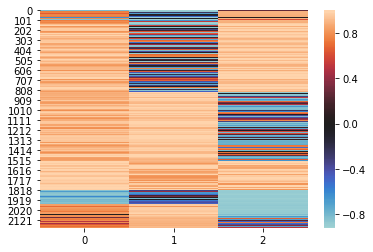

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 478
Task 0 hypothetical scores:


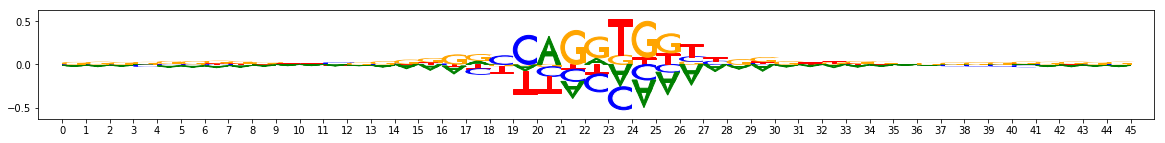

Task 0 actual importance scores:


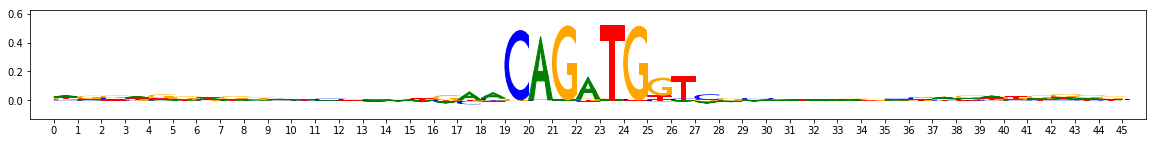

Task 1 hypothetical scores:


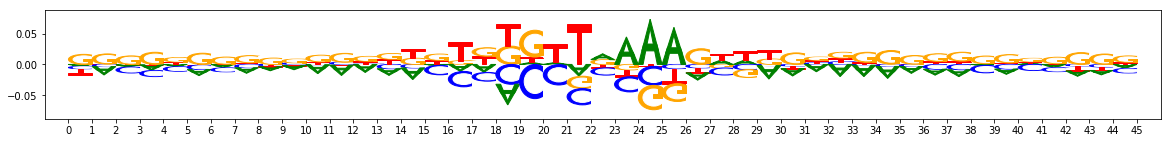

Task 1 actual importance scores:


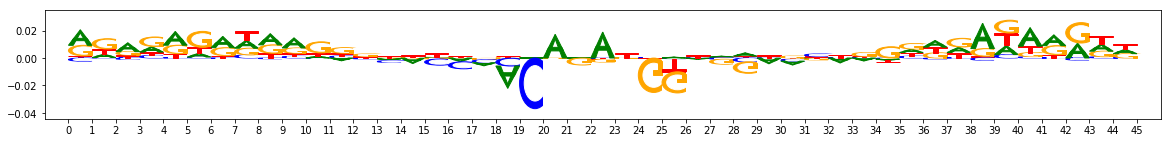

Task 2 hypothetical scores:


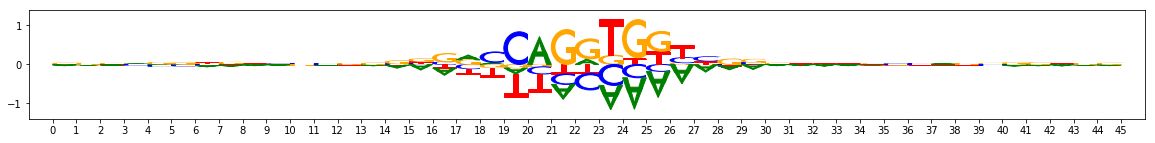

Task 2 actual importance scores:


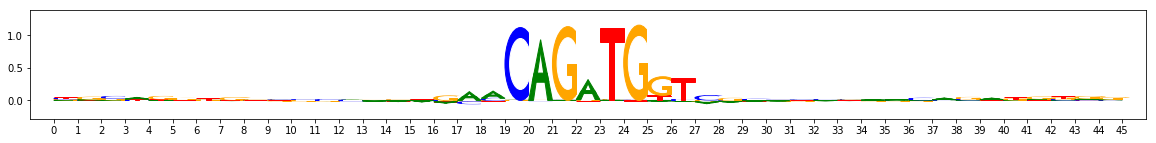

onehot, fwd and rev:


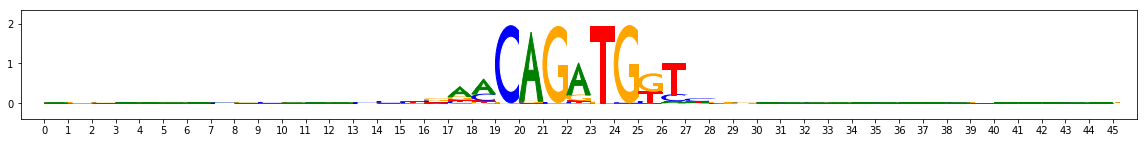

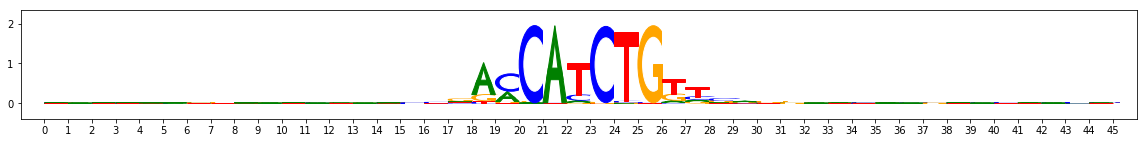

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 392
Task 0 hypothetical scores:


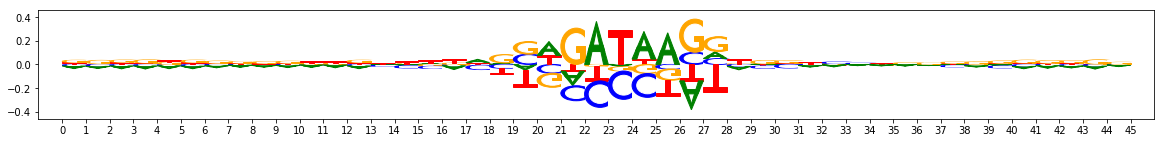

Task 0 actual importance scores:


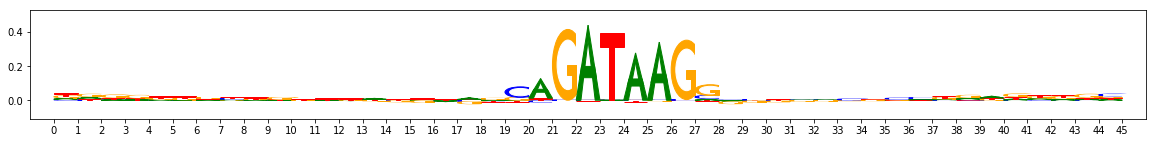

Task 1 hypothetical scores:


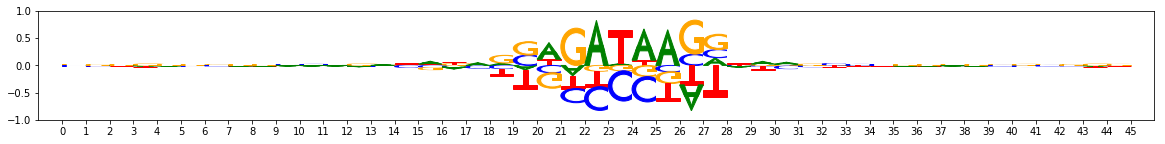

Task 1 actual importance scores:


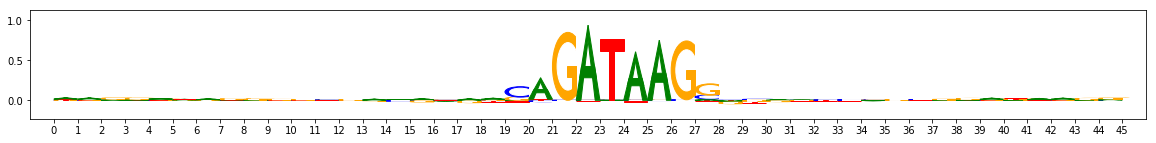

Task 2 hypothetical scores:


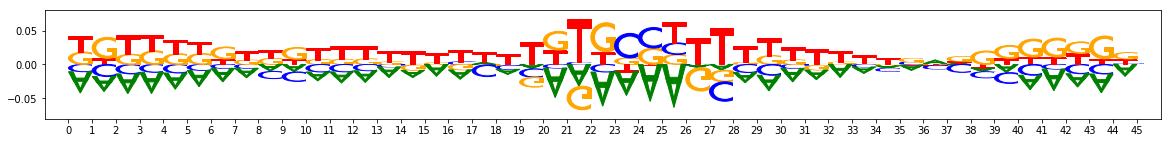

Task 2 actual importance scores:


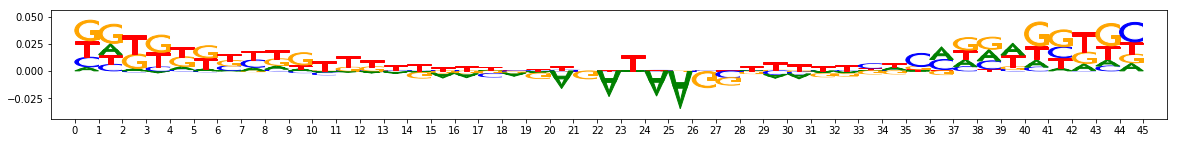

onehot, fwd and rev:


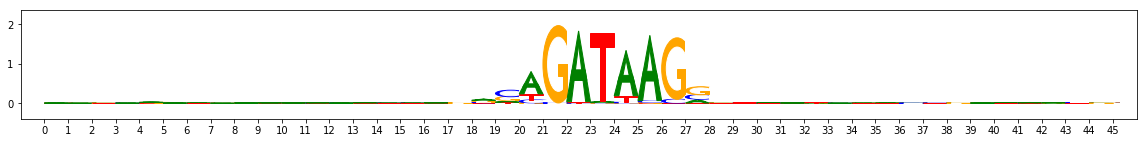

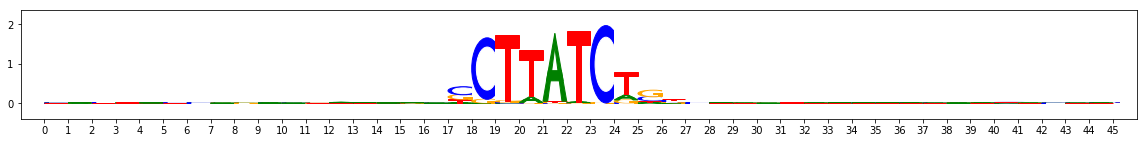

metacluster_2
activity pattern: [1 1 1]
metacluster_2 pattern_0
total seqlets: 147
Task 0 hypothetical scores:


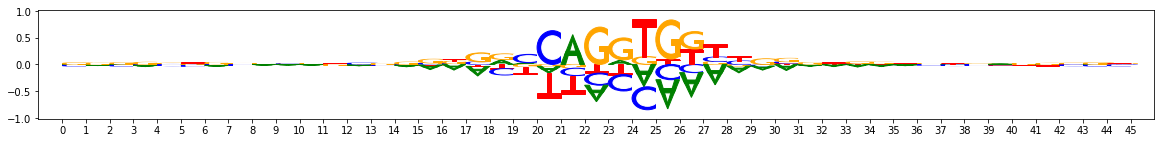

Task 0 actual importance scores:


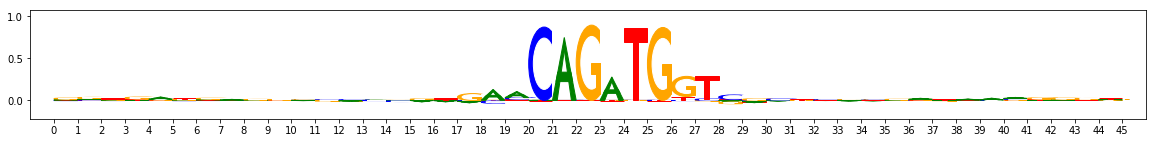

Task 1 hypothetical scores:


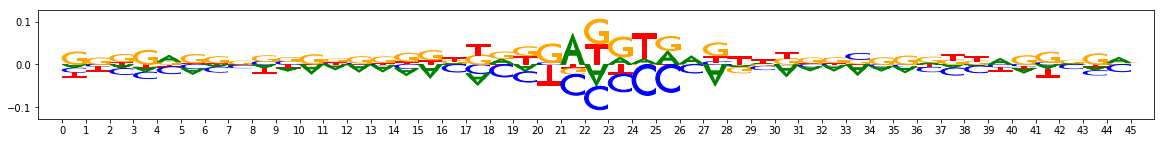

Task 1 actual importance scores:


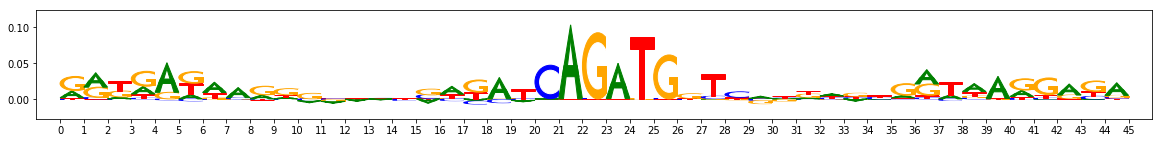

Task 2 hypothetical scores:


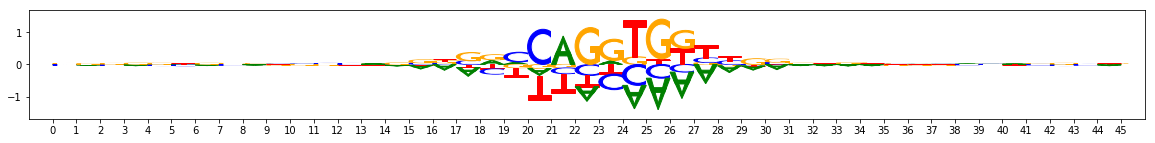

Task 2 actual importance scores:


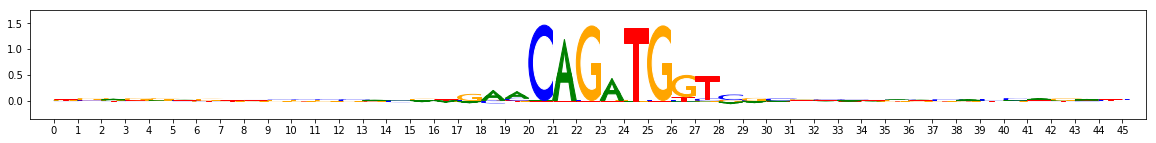

onehot, fwd and rev:


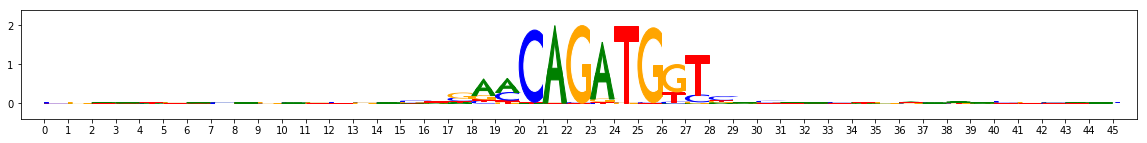

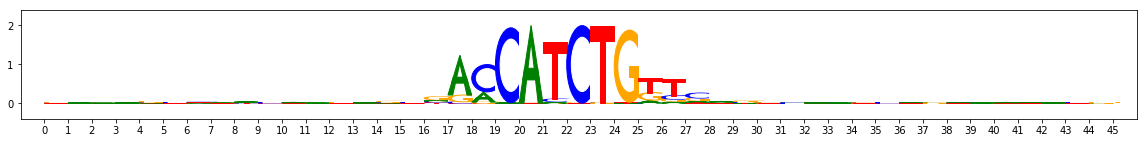

metacluster_2 pattern_1
total seqlets: 68
Task 0 hypothetical scores:


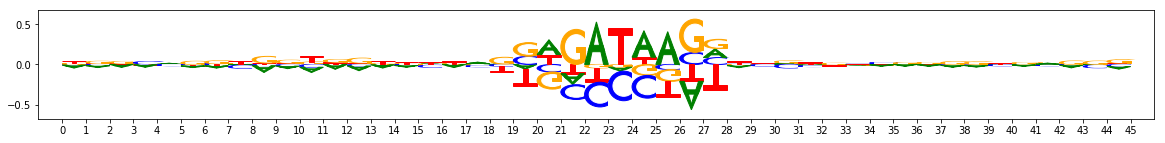

Task 0 actual importance scores:


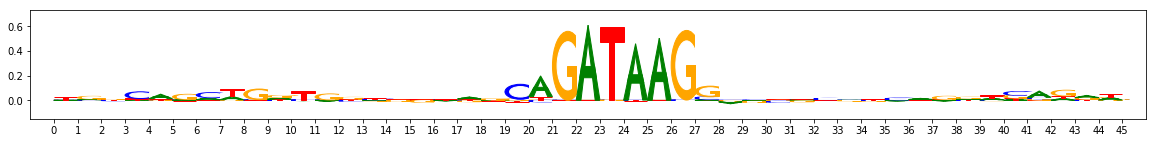

Task 1 hypothetical scores:


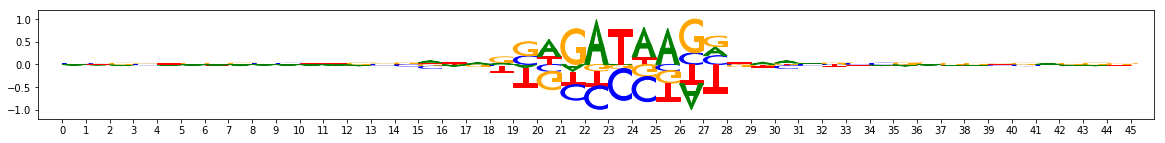

Task 1 actual importance scores:


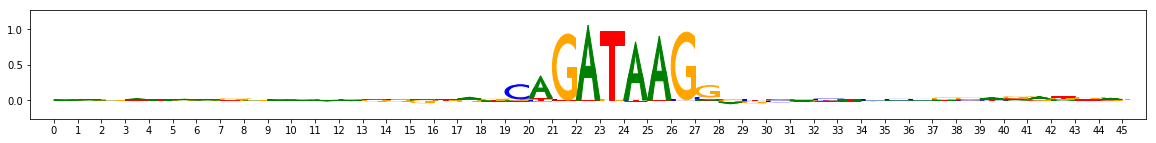

Task 2 hypothetical scores:


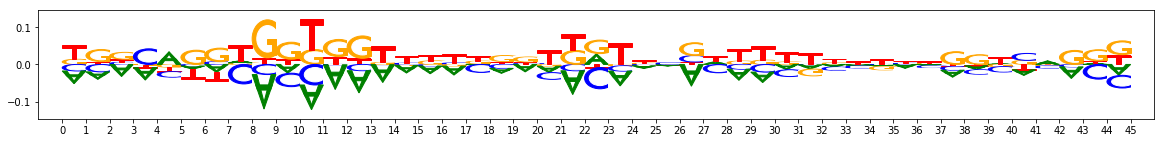

Task 2 actual importance scores:


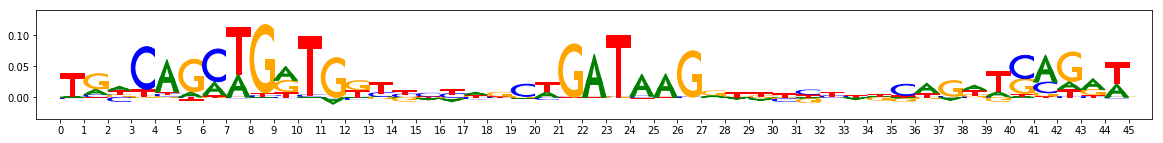

onehot, fwd and rev:


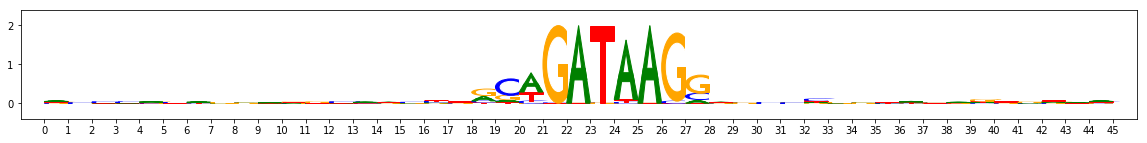

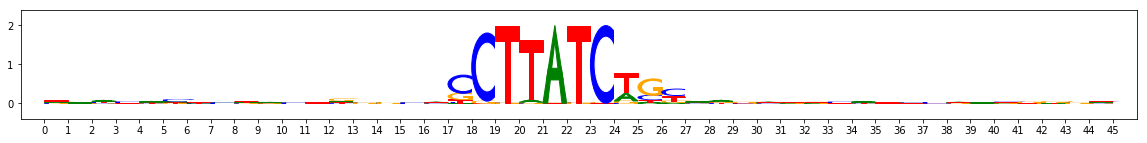

metacluster_3
activity pattern: [ 0  0 -1]
No motifs found for this activity pattern
metacluster_4
activity pattern: [ 0  1 -1]
No motifs found for this activity pattern
metacluster_5
activity pattern: [0 1 0]
No motifs found for this activity pattern


In [9]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Investigate co-enrichment of motifs

TF-MoDISco identified the following motifs:
- "metacluster_0, pattern_0" is the GATA motif (GATAAG) with high importance for both task 0 and task 1
- "metacluster_1, pattern_0" is the TAL motif (CAGATG) with high importance for both task 0 and task 2
- "metacluster_2, pattern_0" is the TAL motif (CAGATG) with high importance for all three tasks
- "metacluster_2, pattern_1" is the GATA motif (GATAAG) with high importance for all three tasks

In the underlying simulation, the TAL motif never directly indicates a 1 for task 1, as task 1 is only positive for sequences containing the GATA motif. Consistent with this, we find that:

- "metacluster_2, pattern_0" (TAL motif that is high for the GATA task) co-occurs with "metacluster_0, pattern_0" and "metacluster_2_pattern_1" (GATA motifs) more than "metacluster_1, pattern_0" (TAL motif that is not high for the GATA task).
- "metacluster_2, pattern_1" (GATA motif that is high for the TAL task) co-occurs  with "metacluster_1, pattern_0" and "metacluster_2, pattern_0" (TAL motifs) more than "metacluster_0, pattern_0" (GATA motif that is not high for the TAL task), although the difference is not statistically significant with these sample sizes

The code to compute this is below:

In [10]:
import scipy.stats
import h5py

hdf5_results = h5py.File("results.hdf5","r")

patterns_to_compare = [
    [("metacluster_1", "pattern_0"), ("metacluster_2", "pattern_0")],
    [("metacluster_0", "pattern_0"), ("metacluster_2", "pattern_1")]
]

for ((pattern1_metacluster, pattern1_name),
     (pattern2_metacluster, pattern2_name)) in patterns_to_compare:
    
    print("Comparing "+pattern1_metacluster+"_"+pattern1_name
          +" and "+pattern2_metacluster+"_"+pattern2_name)
    
    pattern1_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                             [pattern1_metacluster]["seqlets_to_patterns_result"]\
                                             ["patterns"][pattern1_name]["seqlets_and_alnmts"]["seqlets"])
    pattern1_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern1_seqlets])

    pattern2_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                         [pattern2_metacluster]["seqlets_to_patterns_result"]\
                                         ["patterns"][pattern2_name]["seqlets_and_alnmts"]["seqlets"])
    pattern2_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern2_seqlets])

    for (comparison_pattern_metacluster,
         comparison_pattern_name) in all_patterns:
        
        if ((comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern1_metacluster+"_"+pattern1_name)
            and (comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern2_metacluster+"_"+pattern2_name)):
            
            comparison_pattern_seqlets = list(
                hdf5_results["metacluster_idx_to_submetacluster_results"]\
                [comparison_pattern_metacluster]["seqlets_to_patterns_result"]\
                ["patterns"][comparison_pattern_name]["seqlets_and_alnmts"]["seqlets"])
            comparison_pattern_example_idxs = set([
                x.decode("utf-8").split(",")[0].split(":")[1] for x in
                comparison_pattern_seqlets])
        
            
            pattern1_overlap = len(pattern1_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            pattern2_overlap = len(pattern2_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            
            contingency_table = np.array([
                [pattern1_overlap, len(pattern1_example_idxs)-pattern1_overlap],
                [pattern2_overlap, len(pattern2_example_idxs)-pattern2_overlap]])
            odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
            print("Looking at enrichment for "+comparison_pattern_metacluster
                                          +"_"+comparison_pattern_name)
            print("Odds ratio:",odds_ratio,
                  "P-value:",p_value)

            
hdf5_results.close()

Comparing metacluster_1_pattern_0 and metacluster_2_pattern_0
Looking at enrichment for metacluster_0_pattern_0
Odds ratio: 1.284110750810676 P-value: 0.32108144620038315
Looking at enrichment for metacluster_2_pattern_1
Odds ratio: 0.37550675675675677 P-value: 0.005473999771646509
Comparing metacluster_0_pattern_0 and metacluster_2_pattern_1
Looking at enrichment for metacluster_1_pattern_0
Odds ratio: 1.1922876498176134 P-value: 0.660080422220825
Looking at enrichment for metacluster_2_pattern_0
Odds ratio: 0.3048507462686567 P-value: 0.00042892568981618034
